<a href="https://colab.research.google.com/github/AnnaVashuk/ml_neural_networks/blob/main/node_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from sklearn.preprocessing import MinMaxScaler
import time
from io import StringIO

In [ ]:
df = pd.read_csv('d.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


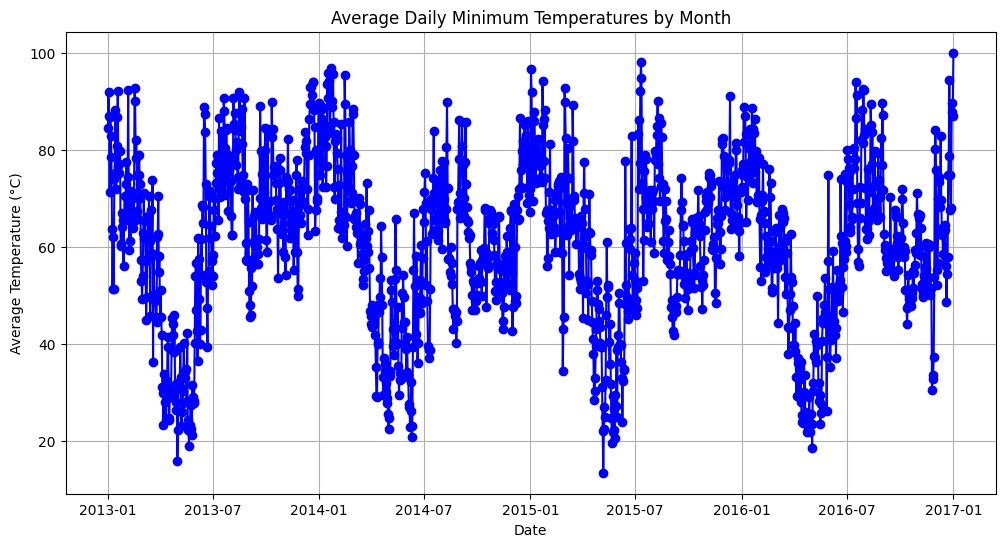

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['humidity'], marker='o', linestyle='-', color='blue')
plt.title('Average Daily Minimum Temperatures by Month')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

In [ ]:
scaler = MinMaxScaler()
df['humidity'] = scaler.fit_transform(df[['humidity']]) #приведем значения к диапазону [0, 1]

In [ ]:
df = df.drop(['meantemp', 'wind_speed', 'meanpressure'], axis=1)
df

,humidity
date,
2013-01-01,0.820957
2013-01-02,0.907591
2013-01-03,0.849835
2013-01-04,0.668867
2013-01-05,0.847910
...,...
2016-12-28,0.630865
2016-12-29,0.859736
2016-12-30,0.880638


Epoch 0, Loss: 0.7999
Epoch 10, Loss: 0.0741
Epoch 20, Loss: 0.0284
Epoch 30, Loss: 0.0190
Epoch 40, Loss: 0.0157
Общее время обучения: 31.05 секунд


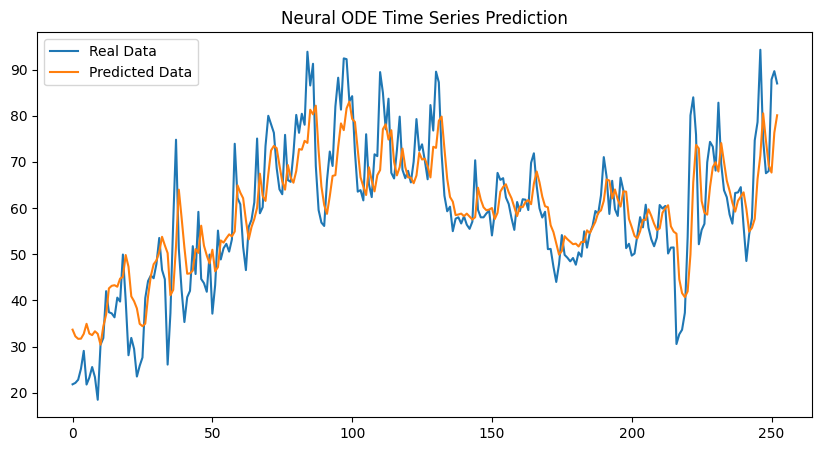

In [ ]:
data = torch.tensor(df['humidity'].values, dtype=torch.float32)
data = torch.nan_to_num(data, nan=0.01) #NaN заменяем на 0.01
data = torch.where(data == 0, torch.tensor(0.01), data) #заменяем все нули на 0.01

#создание обучающих последовательностей
seq_length = 200  #кол-во точек во входной последовательности
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

#преобразуем X в (batch, seq_length, input_dim)
X = torch.stack(X).unsqueeze(-1)  #input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:] #разделение на train и test выборку

#Neural ODE. Определяем функцию динамики
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

#Neural ODE модель
class ODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(ODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #получаем скрытое состояние RNN
        t = torch.linspace(0, 1, steps=10)
        ode_out = odeint(self.odefunc, hidden.squeeze(0), t)  #решаем ODE
        output = self.fc(ode_out[-1])  #прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
model = ODEModel(input_dim, hidden_size)

#оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#счетчик
start_time = time.time()

#обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

#тестирование модели
with torch.no_grad():
    test_preds = model(X_test)

#обратное преобразование нормализации
Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())

plt.figure(figsize=(10,5))
plt.plot(Y_test_inv, label="Real Data")
plt.plot(test_preds_inv, label="Predicted Data")
plt.legend()
plt.title("Neural ODE Time Series Prediction")
plt.show()

Epoch 0, Loss: 0.3073
Epoch 10, Loss: 0.0415
Epoch 20, Loss: 0.0277
Epoch 30, Loss: 0.0172
Epoch 40, Loss: 0.0104
Общее время обучения: 33.97 секунд


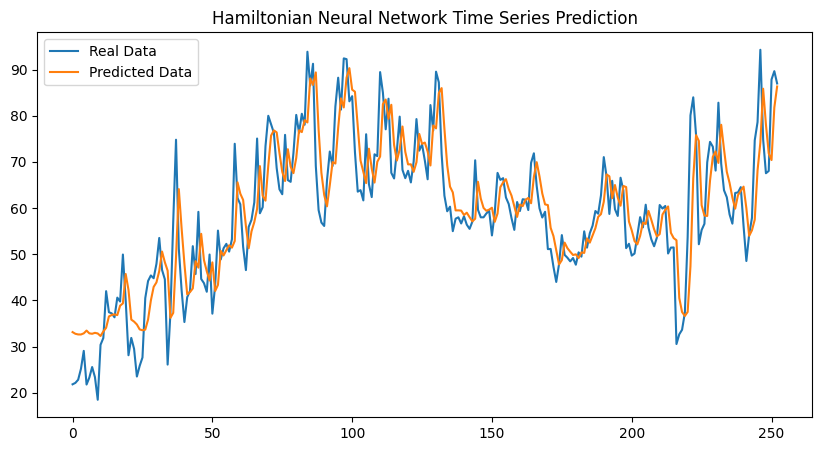

In [ ]:
#Hamiltonian Neural Network. Определяем модель
class HamiltonianNN(nn.Module):
    def __init__(self, hidden_size):
        super(HamiltonianNN, self).__init__()
        self.kinetic = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )
        self.potential = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T, V

#ODE модель с гамильтоновым механизмом
class HNNModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.hnn = HamiltonianNN(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        #прямой проход
        _, hidden = self.rnn(x)  #получаем скрытое состояние RNN
        hidden = hidden.squeeze(0)  #убираем размерность batch

        T, V = self.hnn(hidden) #используем HNN для получения кинетической и потенциальной энергии

        hamiltonian_dynamics = T - V  #итоговая динамика HNN без явного дифференцирования

        output = self.fc(hamiltonian_dynamics) #прогнозируем
        return output

input_dim = 1
hidden_size = 16
model = HNNModel(input_dim, hidden_size)

#оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#счетчик
start_time = time.time()

#обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

#тестирование модели
with torch.no_grad():
    test_preds = model(X_test)

#обратное преобразование нормализации
Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())

plt.figure(figsize=(10,5))
plt.plot(Y_test_inv, label="Real Data")
plt.plot(test_preds_inv, label="Predicted Data")
plt.legend()
plt.title("Hamiltonian Neural Network Time Series Prediction")
plt.show()

Epoch 0, Loss: 0.2397
Epoch 10, Loss: 0.0286
Epoch 20, Loss: 0.0291
Epoch 30, Loss: 0.0174
Epoch 40, Loss: 0.0150
Общее время обучения: 41.88 секунд


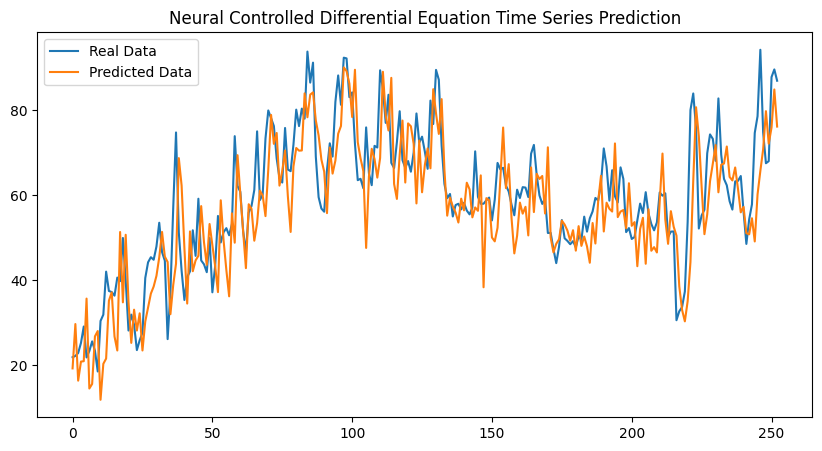

In [ ]:
#Neural Controlled Differential Equation (NCDE). Определяем функцию динамики с контролем
class NCDEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(NCDEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x, control):
        #управление добавляется к динамике
        return self.net(x) + control  #контроль влияет на изменение состояния

#NCDE модель
class NCDEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NCDEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.ncdefunc = NCDEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #получаем скрытое состояние RNN
        t = torch.linspace(0, 1, steps=10)
        control = torch.randn_like(hidden)*0.1  #случайный контроль, который влияет на динамику
        ode_out = odeint(lambda t, x: self.ncdefunc(t, x, control), hidden.squeeze(0), t)
        output = self.fc(ode_out[-1])  #прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
model = NCDEModel(input_dim, hidden_size)

#оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#счетчик
start_time = time.time()

#обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

#тестирование модели
with torch.no_grad():
    test_preds = model(X_test)

#обратное преобразование нормализации
Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())

plt.figure(figsize=(10,5))
plt.plot(Y_test_inv, label="Real Data")
plt.plot(test_preds_inv, label="Predicted Data")
plt.legend()
plt.title("Neural Controlled Differential Equation Time Series Prediction")
plt.show()

Epoch 0, Loss: 0.0909
Epoch 10, Loss: 0.0243
Epoch 20, Loss: 0.0131
Epoch 30, Loss: 0.0091
Epoch 40, Loss: 0.0089
Общее время обучения: 40.18 секунд


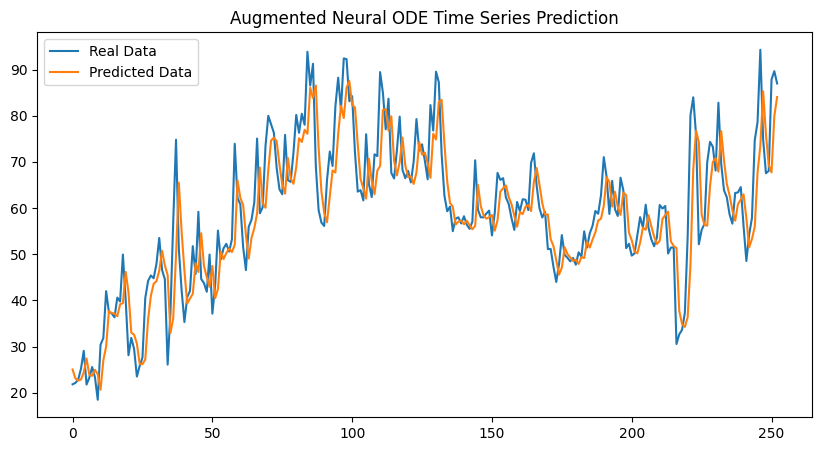

In [ ]:
#Augmented Neural ODE. Определяем функцию динамики
class AugmentedODEFunc(nn.Module):
    def __init__(self, hidden_size, aug_dim=2):
        super(AugmentedODEFunc, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim  #добавляем дополнительные измерения
        self.net = nn.Sequential(
            nn.Linear(hidden_size + aug_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size + aug_dim)
        )

    def forward(self, t, x):
        return self.net(x)

#Augmented Neural ODE модель
class AugmentedODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size, aug_dim=2):
        super(AugmentedODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = AugmentedODEFunc(hidden_size, aug_dim)
        self.fc = nn.Linear(hidden_size + aug_dim, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #получаем скрытое состояние RNN
        hidden = hidden.squeeze(0)

        aug_hidden = torch.cat([hidden, torch.zeros(hidden.shape[0], self.aug_dim)], dim=1)  #добавляем дополнительные измерения

        t = torch.linspace(0, 1, steps=10)
        ode_out = odeint(self.odefunc, aug_hidden, t)  #решаем ODE в увеличенном пространстве

        output = self.fc(ode_out[-1])  #прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
aug_dim = 2  #добавляем 2 дополнительных измерения
model = AugmentedODEModel(input_dim, hidden_size, aug_dim)

#оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#счетчик
start_time = time.time()

#обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

#тестирование модели
with torch.no_grad():
    test_preds = model(X_test)

#обратное преобразование нормализации
Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())

plt.figure(figsize=(10,5))
plt.plot(Y_test_inv, label="Real Data")
plt.plot(test_preds_inv, label="Predicted Data")
plt.legend()
plt.title("Augmented Neural ODE Time Series Prediction")
plt.show()


Epoch 0, Loss: 0.6384
Epoch 10, Loss: 0.0681
Epoch 20, Loss: 0.0278
Epoch 30, Loss: 0.0190
Epoch 40, Loss: 0.0126
Общее время обучения: 30.01 секунд


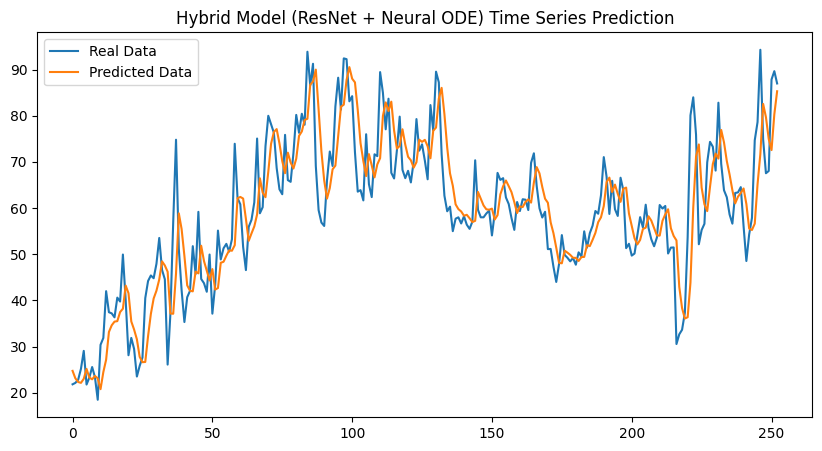

In [ ]:
#обычный ResNet блок
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        return x + self.net(x)

#Neural ODE. Определяем функцию динамики
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

#модель, которая использует либо ResNet, либо ODE в зависимости от вероятности p = 1/t
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HybridModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.resnet = ResNetBlock(hidden_size)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #(batch, seq_len, hidden_size)
        hidden = hidden.squeeze(0)  #получаем скрытое состояние RNN

        t = torch.linspace(0, 1, steps=10).to(x.device)
        p = 1.0 / t #считаем вероятность p = 1/t для выбора между ResNet и ODE

        #условие вероятности
        if torch.rand(1).item() < p[-1].item():
            ode_out = odeint(self.odefunc, hidden, t)  #решаем ODE
            output = self.fc(ode_out[-1])  #прогнозируем будущее значение
        else:
            output = self.fc(self.resnet(hidden))  #прогнозируем через ResNet

        return output

input_dim = 1
hidden_size = 16
model = HybridModel(input_dim, hidden_size)

#оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#счетчик времени
start_time = time.time()

#обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

#тестирование модели
with torch.no_grad():
    test_preds = model(X_test)

#обратное преобразование нормализации
Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())

plt.figure(figsize=(10,5))
plt.plot(Y_test_inv, label="Real Data")
plt.plot(test_preds_inv, label="Predicted Data")
plt.legend()
plt.title("Hybrid Model (ResNet + Neural ODE) Time Series Prediction")
plt.show()